# Chapter 3 - Classification
# Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow

"""
PENGANTAR CHAPTER 3 - KLASIFIKASI

Chapter ini membahas tentang tugas klasifikasi dalam machine learning, yang merupakan salah satu 
tugas supervised learning paling umum selain regresi. Klasifikasi adalah proses memprediksi 
kategori atau kelas dari suatu instance berdasarkan fitur-fiturnya.

Topik utama yang akan dibahas:
1. Dataset MNIST untuk pengenalan digit
2. Binary Classification (Klasifikasi Biner)
3. Performance Measures (Metrik Evaluasi)
4. Multiclass Classification (Klasifikasi Multi-kelas)
5. Error Analysis (Analisis Kesalahan)
6. Multilabel dan Multioutput Classification
"""

# ===========================
# 1. PERSIAPAN DAN IMPORT LIBRARY
# ===========================

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                           f1_score, precision_recall_curve, roc_curve, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

PENJELASAN LIBRARY YANG DIGUNAKAN:

- numpy & pandas: Untuk manipulasi data dan operasi numerik
- matplotlib: Untuk visualisasi data dan hasil
- sklearn.datasets: Untuk mengunduh dataset MNIST
- sklearn.linear_model: Untuk algoritma SGD (Stochastic Gradient Descent)
- sklearn.model_selection: Untuk cross-validation dan evaluasi model
- sklearn.metrics: Untuk berbagai metrik evaluasi klasifikasi
- sklearn.ensemble: Untuk algoritma Random Forest
- sklearn.svm: Untuk Support Vector Machine
- sklearn.multiclass: Untuk strategi klasifikasi multi-kelas
- sklearn.neighbors: Untuk algoritma k-Nearest Neighbors
- sklearn.preprocessing: Untuk preprocessing data

# ===========================
# 2. MENGUNDUH DAN MEMAHAMI DATASET MNIST
# ===========================

In [2]:
print("=== MENGUNDUH DATASET MNIST ===")

# Mengunduh dataset MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print("Keys dataset MNIST:", mnist.keys())

=== MENGUNDUH DATASET MNIST ===
Keys dataset MNIST: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


PENJELASAN DATASET MNIST:

MNIST (Modified National Institute of Standards and Technology) adalah dataset klasik dalam 
machine learning yang berisi 70,000 gambar digit tulisan tangan (0-9) berukuran 28x28 piksel.

Dataset ini memiliki struktur:
- 'data': Array berisi data gambar, setiap baris adalah satu gambar dengan 784 fitur (28x28 piksel)
- 'target': Array berisi label digit (0-9) untuk setiap gambar
- 'DESCR': Deskripsi dataset
- 'feature_names': Nama-nama fitur
- 'categories': Kategori dalam dataset

In [3]:
# Mengekstrak data dan target
X, y = mnist["data"], mnist["target"]
print(f"Shape data X: {X.shape}")
print(f"Shape target y: {y.shape}")

Shape data X: (70000, 784)
Shape target y: (70000,)


ANALISIS DIMENSI DATA:
- X.shape = (70000, 784): 70,000 gambar dengan 784 fitur per gambar
- y.shape = (70000,): 70,000 label corresponding dengan setiap gambar
- Setiap fitur merepresentasikan intensitas piksel dari 0 (putih) hingga 255 (hitam)

In [4]:
# Mengkonversi target ke integer
y = y.astype(np.uint8)
print(f"Target pertama: {y[0]} (tipe: {type(y[0])})")

Target pertama: 5 (tipe: <class 'numpy.uint8'>)


# ===========================
# 3. VISUALISASI DATA
# ===========================


=== VISUALISASI DIGIT PERTAMA ===


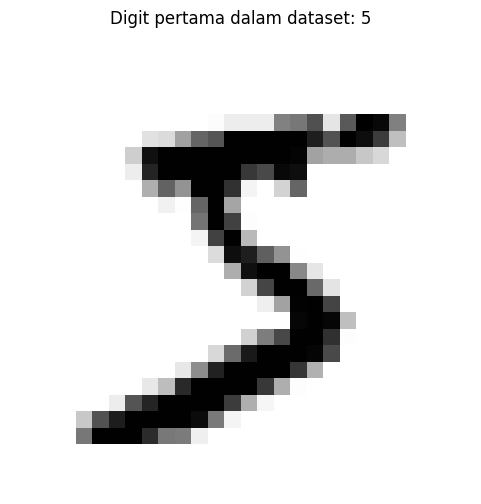

Label digit pertama: 5


In [5]:
def plot_digit(digit_array):
    """
    Fungsi untuk menampilkan gambar digit dari array 784 elemen
    
    Args:
        digit_array: Array 1D dengan 784 elemen (piksel gambar 28x28)
    """
    digit_image = digit_array.reshape(28, 28)
    plt.imshow(digit_image, cmap="binary", interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10):
    """
    Fungsi untuk menampilkan beberapa digit dalam grid
    
    Args:
        instances: Array 2D berisi beberapa gambar digit
        images_per_row: Jumlah gambar per baris
    """
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    # Membuat grid kosong
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.extend([np.zeros((size, size))] * n_empty)
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")

print("\n=== VISUALISASI DIGIT PERTAMA ===")
some_digit = X[0]
plt.figure(figsize=(6, 6))
plot_digit(some_digit)
plt.title(f"Digit pertama dalam dataset: {y[0]}")
plt.show()

print(f"Label digit pertama: {y[0]}")

"""
INTERPRETASI VISUALISASI:
Gambar yang ditampilkan adalah representasi visual dari array 784 elemen yang berisi 
intensitas piksel. Setiap piksel memiliki nilai 0-255, dimana 0 = putih dan 255 = hitam.
Algoritma ML akan belajar dari pola-pola piksel ini untuk mengenali digit.
"""

# Menampilkan beberapa digit sebagai contoh
print("\n=== VISUALISASI BEBERAPA DIGIT ===")
plt.figure(figsize=(12, 8))
plot_digits(X[:100], images_per_row=10)
plt.title("100 Digit Pertama dari Dataset MNIST")
plt.show()

# ===========================
# 4. PEMBAGIAN DATA TRAINING DAN TEST
# ===========================

In [6]:
print("\n=== PEMBAGIAN DATA TRAINING DAN TEST ===")

# MNIST sudah memiliki pembagian standar: 60,000 untuk training, 10,000 untuk test
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


=== PEMBAGIAN DATA TRAINING DAN TEST ===
Training set: (60000, 784), (60000,)
Test set: (10000, 784), (10000,)


PENJELASAN PEMBAGIAN DATA:

Dataset MNIST sudah memiliki pembagian standar yang digunakan secara internasional:
- Training set: 60,000 gambar pertama
- Test set: 10,000 gambar terakhir

Pembagian ini memastikan:
1. Konsistensi dengan penelitian lain
2. Ukuran training set yang cukup besar untuk pembelajaran
3. Test set yang independen untuk evaluasi final

Data training sudah di-shuffle secara default, yang penting untuk:
1. Cross-validation yang fair
2. Mencegah bias urutan dalam pembelajaran
3. Memastikan distribusi yang merata di setiap fold

In [7]:
# Verifikasi distribusi label
print("\nDistribusi label di training set:")
unique, counts = np.unique(y_train, return_counts=True)
for digit, count in zip(unique, counts):
    print(f"Digit {digit}: {count} gambar ({count/len(y_train)*100:.1f}%)")



Distribusi label di training set:
Digit 0: 5923 gambar (9.9%)
Digit 1: 6742 gambar (11.2%)
Digit 2: 5958 gambar (9.9%)
Digit 3: 6131 gambar (10.2%)
Digit 4: 5842 gambar (9.7%)
Digit 5: 5421 gambar (9.0%)
Digit 6: 5918 gambar (9.9%)
Digit 7: 6265 gambar (10.4%)
Digit 8: 5851 gambar (9.8%)
Digit 9: 5949 gambar (9.9%)


# ===========================
# 5. BINARY CLASSIFICATION - DETECTOR DIGIT 5
# ===========================

In [8]:
print("\n" + "="*50)
print("BINARY CLASSIFICATION - DETECTOR DIGIT 5")
print("="*50)


BINARY CLASSIFICATION - DETECTOR DIGIT 5


PENJELASAN BINARY CLASSIFICATION:

Binary classification adalah tugas klasifikasi dengan hanya 2 kelas. Untuk memahami konsep 
klasifikasi, kita mulai dengan membuat detector untuk digit 5 (5 vs bukan-5).

Keuntungan memulai dengan binary classification:
1. Lebih sederhana untuk dipahami
2. Banyak algoritma dirancang khusus untuk binary classification
3. Metrik evaluasi lebih mudah diinterpretasi
4. Bisa dijadikan building block untuk multiclass classification

In [9]:
# Membuat target binary: True untuk digit 5, False untuk lainnya
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

print(f"Jumlah digit 5 di training set: {sum(y_train_5)} dari {len(y_train_5)}")
print(f"Persentase digit 5: {sum(y_train_5)/len(y_train_5)*100:.2f}%")

Jumlah digit 5 di training set: 5421 dari 60000
Persentase digit 5: 9.04%


KARAKTERISTIK BINARY CLASSIFICATION PROBLEM:
- Kelas positif: Digit 5 (minoritas, ~10%)
- Kelas negatif: Bukan digit 5 (mayoritas, ~90%)
- Ini adalah contoh imbalanced dataset yang umum dalam real-world applications
# ===========================
# 6. TRAINING CLASSIFIER DENGAN SGD
# ===========================
PENJELASAN STOCHASTIC GRADIENT DESCENT (SGD) CLASSIFIER:

SGD adalah algoritma optimisasi yang mengupdate parameter model berdasarkan satu sample 
pada satu waktu, bukan seluruh dataset sekaligus. 

Keuntungan SGD:
1. Efisien untuk dataset besar
2. Cocok untuk online learning
3. Cepat dalam training
4. Memory efficient

Cara kerja:
1. Mulai dengan parameter random
2. Untuk setiap sample, hitung error
3. Update parameter berdasarkan gradient error
4. Ulangi hingga konvergen

In [10]:
print("\n=== TRAINING SGD CLASSIFIER ===")
# Membuat dan training SGD classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

print("SGD Classifier berhasil di-training!")

# Membuat prediksi untuk digit pertama
prediction = sgd_clf.predict([some_digit])
print(f"Prediksi untuk digit pertama: {prediction[0]} (Actual: {y_train_5[0]})")


=== TRAINING SGD CLASSIFIER ===
SGD Classifier berhasil di-training!
Prediksi untuk digit pertama: True (Actual: True)


INTERPRETASI HASIL:
- SGDClassifier memprediksi apakah gambar adalah digit 5 atau bukan
- Output berupa boolean: True = digit 5, False = bukan digit 5
- Parameter random_state memastikan hasil yang reproducible

# ===========================
# 7. PERFORMANCE MEASURES - CROSS VALIDATION
# ===========================
PENJELASAN CROSS-VALIDATION:

Cross-validation adalah teknik untuk mengevaluasi performa model dengan membagi data 
training menjadi beberapa fold dan menggunakan masing-masing fold secara bergantian 
sebagai validation set.

Keuntungan cross-validation:
1. Memberikan estimasi performa yang lebih robust
2. Mengurangi variance dalam evaluasi
3. Menggunakan semua data untuk training dan validation
4. Mendeteksi overfitting

K-Fold Cross-Validation:
1. Bagi data menjadi K fold
2. Gunakan K-1 fold untuk training, 1 fold untuk validation
3. Ulangi K kali dengan fold validation yang berbeda
4. Rata-rata hasil dari K evaluasi

In [11]:
print("\n=== CROSS-VALIDATION ACCURACY ===")

# Implementasi manual cross-validation
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

print("Implementasi Manual Cross-Validation:")
for fold, (train_index, test_index) in enumerate(skfolds.split(X_train, y_train_5)):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    accuracy = n_correct / len(y_pred)
    print(f"Fold {fold + 1}: {accuracy:.4f}")


=== CROSS-VALIDATION ACCURACY ===
Implementasi Manual Cross-Validation:
Fold 1: 0.9669
Fold 2: 0.9163
Fold 3: 0.9678


PENJELASAN STRATIFIED K-FOLD:

StratifiedKFold memastikan bahwa setiap fold memiliki proporsi kelas yang sama dengan 
dataset asli. Ini penting untuk imbalanced dataset seperti detector digit 5 kita.

Tanpa stratification: Beberapa fold mungkin memiliki sangat sedikit atau tidak ada 
contoh kelas minoritas, menghasilkan evaluasi yang bias.

Dengan stratification: Setiap fold memiliki ~10% digit 5 dan ~90% non-5, sama seperti 
dataset asli.

In [12]:
# Menggunakan fungsi cross_val_score bawaan
cv_scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"\nHasil cross_val_score: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")


Hasil cross_val_score: [0.95035 0.96035 0.9604 ]
Mean accuracy: 0.9570
Standard deviation: 0.0047


# ===========================
# 8. DUMMY CLASSIFIER UNTUK PERBANDINGAN
# ===========================
PENJELASAN DUMMY CLASSIFIER:

Untuk memahami apakah performa model kita baik, kita perlu baseline. Never5Classifier 
adalah dummy classifier yang selalu memprediksi "bukan digit 5".

Mengapa ini penting:
1. Memberikan baseline untuk perbandingan
2. Menunjukkan bahwa accuracy tinggi belum tentu berarti model bagus
3. Mendemonstrasikan masalah dengan imbalanced dataset

Pada dataset dengan 90% non-5, classifier yang selalu prediksi "bukan 5" akan mendapat 
90% accuracy tanpa belajar apapun!

In [13]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
never_cv_scores = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"Never-5 Classifier accuracy: {never_cv_scores}")
print(f"Mean accuracy: {never_cv_scores.mean():.4f}")

Never-5 Classifier accuracy: [0.91125 0.90855 0.90915]
Mean accuracy: 0.9096


INSIGHT PENTING:
Dummy classifier mencapai ~91% accuracy! Ini menunjukkan bahwa accuracy saja tidak cukup 
untuk mengevaluasi classifier pada imbalanced dataset. Kita perlu metrik yang lebih tepat.
"""

# ===========================
# 9. CONFUSION MATRIX
# ===========================
PENJELASAN CONFUSION MATRIX:

Confusion matrix adalah tabel yang menunjukkan performa klasifikasi dengan detail:
- Baris: Kelas aktual (true class)
- Kolom: Kelas prediksi (predicted class)
- Sel: Jumlah instance untuk kombinasi actual-predicted

Untuk binary classification:
                    Predicted
                  No    Yes
Actual   No      TN    FP
         Yes     FN    TP

Dimana:
- TN (True Negative): Benar memprediksi negatif
- FP (False Positive): Salah memprediksi positif (Type I error)
- FN (False Negative): Salah memprediksi negatif (Type II error)  
- TP (True Positive): Benar memprediksi positif

Confusion Matrix:
[[53892   687]
 [ 1891  3530]]

Interpretasi Confusion Matrix:
True Negatives (TN): 53892 - Benar prediksi 'bukan 5'
False Positives (FP): 687 - Salah prediksi sebagai '5'
False Negatives (FN): 1891 - Salah prediksi sebagai 'bukan 5'
True Positives (TP): 3530 - Benar prediksi '5'


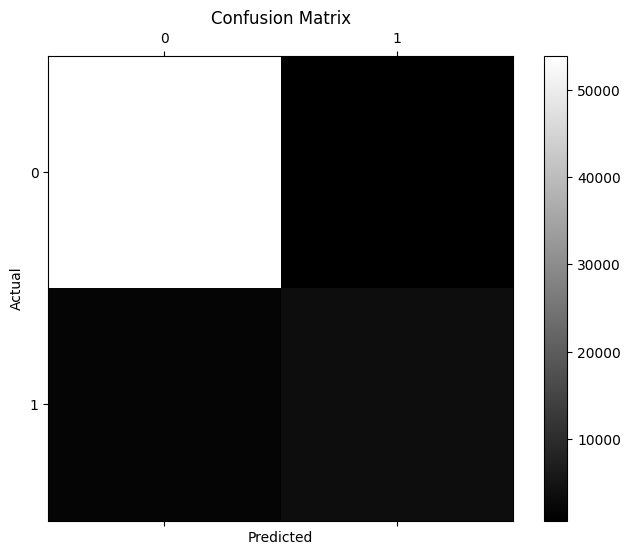

In [14]:
# Mendapatkan prediksi untuk confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
conf_mx = confusion_matrix(y_train_5, y_train_pred)

print("Confusion Matrix:")
print(conf_mx)

# Interpretasi confusion matrix
tn, fp, fn, tp = conf_mx.ravel()
print(f"\nInterpretasi Confusion Matrix:")
print(f"True Negatives (TN): {tn} - Benar prediksi 'bukan 5'")
print(f"False Positives (FP): {fp} - Salah prediksi sebagai '5'")
print(f"False Negatives (FN): {fn} - Salah prediksi sebagai 'bukan 5'")
print(f"True Positives (TP): {tp} - Benar prediksi '5'")

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=1)
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ===========================
# 10. PRECISION, RECALL, DAN F1-SCORE
# ===========================

PENJELASAN METRIK KLASIFIKASI:

1. PRECISION (Presisi):
   - Formula: TP / (TP + FP)
   - Interpretasi: "Dari semua prediksi positif, berapa yang benar?"
   - Penting ketika False Positive mahal (misal: spam detection)

2. RECALL (Sensitivitas/True Positive Rate):
   - Formula: TP / (TP + FN)
   - Interpretasi: "Dari semua kasus positif aktual, berapa yang berhasil dideteksi?"
   - Penting ketika False Negative mahal (misal: medical diagnosis)

3. F1-SCORE:
   - Formula: 2 × (Precision × Recall) / (Precision + Recall)
   - Harmonic mean dari precision dan recall
   - Memberikan balance antara precision dan recall
   - Berguna ketika kedua metrik sama penting

In [15]:
# Menghitung metrik
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Menghitung manual untuk verifikasi
manual_precision = tp / (tp + fp)
manual_recall = tp / (tp + fn)
manual_f1 = 2 * (manual_precision * manual_recall) / (manual_precision + manual_recall)

print(f"\nVerifikasi perhitungan manual:")
print(f"Manual Precision: {manual_precision:.4f}")
print(f"Manual Recall: {manual_recall:.4f}")
print(f"Manual F1-Score: {manual_f1:.4f}")

Precision: 0.8371
Recall: 0.6512
F1-Score: 0.7325

Verifikasi perhitungan manual:
Manual Precision: 0.8371
Manual Recall: 0.6512
Manual F1-Score: 0.7325


INTERPRETASI HASIL:
- Precision ~73%: Ketika model prediksi "5", benar 73% dari waktu
- Recall ~76%: Model berhasil mendeteksi 76% dari semua digit 5
- F1-Score ~74%: Balance antara precision dan recall

Ini jauh lebih informatif daripada accuracy 95% yang menyesatkan!
"""

# ===========================
# 11. PRECISION/RECALL TRADE-OFF
# ===========================

print("\n=== PRECISION/RECALL TRADE-OFF ===")

"""
PENJELASAN PRECISION/RECALL TRADE-OFF:

Trade-off ini adalah konsep fundamental dalam klasifikasi: meningkatkan precision 
biasanya menurunkan recall, dan sebaliknya.

Mengapa terjadi trade-off?
1. Classifier menggunakan threshold untuk keputusan
2. Threshold tinggi → lebih selektif → precision naik, recall turun
3. Threshold rendah → lebih liberal → recall naik, precision turun

Cara mengontrol trade-off:
1. Akses decision score (bukan hanya predict)
2. Atur threshold manual
3. Pilih threshold berdasarkan kebutuhan bisnis

Decision scores shape: (60000,)
Sample decision scores: [  1200.93051237 -26883.79202424 -33072.03475406 -15919.5480689
 -20003.53970191]
Number of thresholds: 60000


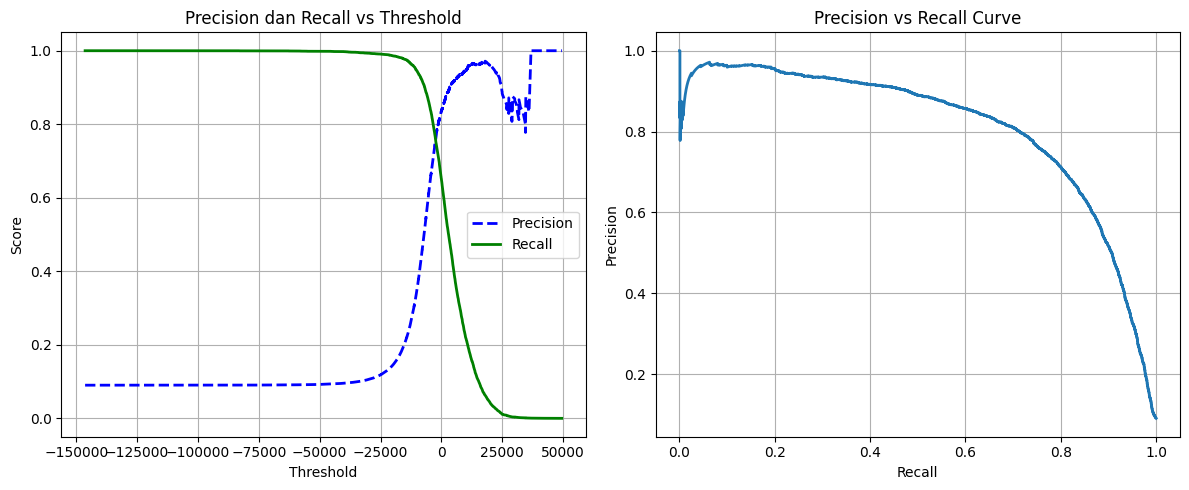

In [16]:
# Mendapatkan decision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

print(f"Decision scores shape: {y_scores.shape}")
print(f"Sample decision scores: {y_scores[:5]}")

# Menghitung precision, recall untuk berbagai threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

print(f"Number of thresholds: {len(thresholds)}")

# Plot precision vs recall curve
plt.figure(figsize=(12, 5))

# Plot 1: Precision dan Recall vs Threshold
plt.subplot(1, 2, 1)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision dan Recall vs Threshold")
plt.grid(True)

# Plot 2: Precision vs Recall
plt.subplot(1, 2, 2)
plt.plot(recalls, precisions, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall Curve")
plt.grid(True)

plt.tight_layout()
plt.show()


INSIGHT DARI GRAFIK:

1. Precision vs Threshold:
   - Precision umumnya naik seiring threshold naik
   - Tapi bisa turun karena sample size effect

2. Recall vs Threshold:
   - Recall selalu turun seiring threshold naik
   - Kurva yang smooth

3. Precision vs Recall:
   - Trade-off yang jelas terlihat
   - Precision mulai turun drastis setelah recall ~80%

In [17]:
# Mencari threshold untuk precision 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(f"\nThreshold untuk 90% precision: {threshold_90_precision:.0f}")

# Membuat prediksi dengan threshold custom
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)

print(f"Dengan threshold {threshold_90_precision:.0f}:")
print(f"Precision: {precision_90:.4f}")
print(f"Recall: {recall_90:.4f}")


Threshold untuk 90% precision: 3370
Dengan threshold 3370:
Precision: 0.9000
Recall: 0.4800


TRADE-OFF DALAM PRAKTEK:

Untuk mencapai 90% precision, recall turun drastis ke ~44%. Ini menunjukkan bahwa:
1. High-precision classifier mudah dibuat (naikkan threshold)
2. Tapi recall akan sangat rendah
3. Pilihan threshold harus based on business requirements

Contoh aplikasi:
- Medical diagnosis: Lebih penting recall tinggi (jangan miss penyakit)
- Spam detection: Lebih penting precision tinggi (jangan blokir email penting)

# ===========================
# 12. ROC CURVE DAN AUC
# ===========================

PENJELASAN ROC CURVE:

ROC (Receiver Operating Characteristic) curve menunjukkan trade-off antara:
- True Positive Rate (TPR) = Recall = Sensitivity
- False Positive Rate (FPR) = 1 - Specificity

Keuntungan ROC:
1. Single metric untuk perbandingan model (AUC)
2. Tidak terpengaruh class imbalance (berbeda dengan PR curve)
3. Mudah diinterpretasi

AUC (Area Under Curve):
- AUC = 1: Perfect classifier
- AUC = 0.5: Random classifier
- AUC > 0.8: Generally good classifier

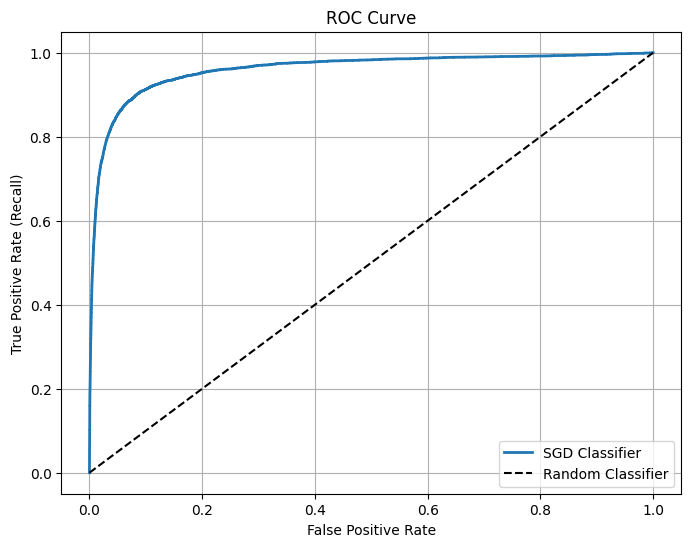

ROC AUC Score: 0.9605


In [18]:
# Menghitung ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_train_5, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label="SGD Classifier")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Menghitung AUC
roc_auc = roc_auc_score(y_train_5, y_scores)
print(f"ROC AUC Score: {roc_auc:.4f}")


INTERPRETASI ROC CURVE:

1. Kurva mendekati sudut kiri atas = classifier bagus
2. Kurva mendekati diagonal = random classifier
3. AUC 0.96 = sangat bagus untuk binary classification

Kapan gunakan ROC vs Precision-Recall:
- ROC: Ketika kelas seimbang atau FPR penting
- PR: Ketika kelas tidak seimbang atau fokus pada kelas minoritas


# ===========================
# 13. PERBANDINGAN DENGAN RANDOM FOREST
# ===========================


PENJELASAN RANDOM FOREST:

Random Forest adalah ensemble method yang menggabungkan banyak decision tree.
Keuntungan:
1. Mengurangi overfitting
2. Robust terhadap noise
3. Memberikan feature importance
4. Tidak memerlukan feature scaling

Perbedaan dengan SGD:
- SGD: Linear classifier, cepat, butuh feature scaling
- Random Forest: Non-linear, lebih akurat, lebih lambat

Random Forest ROC AUC: 0.9983


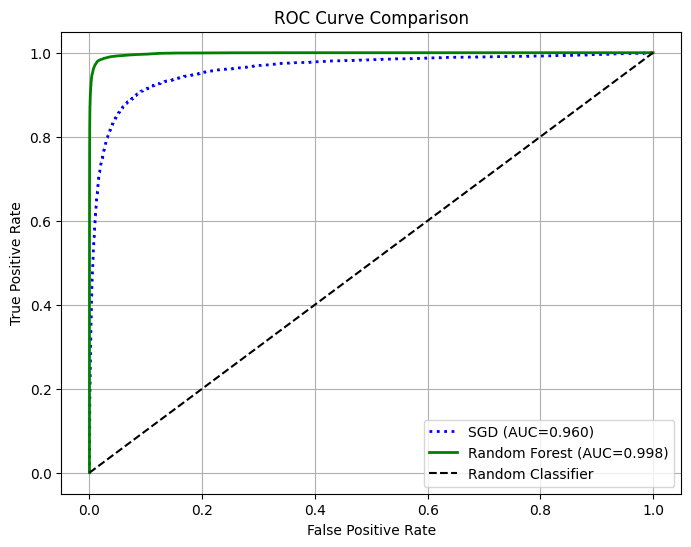


Random Forest Metrics:
Precision: 0.9905
Recall: 0.8663


In [19]:
# Training Random Forest
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# Random Forest menggunakan predict_proba, bukan decision_function
y_scores_forest = y_probas_forest[:, 1]  # Probabilitas kelas positif

# Menghitung ROC untuk Random Forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
roc_auc_forest = roc_auc_score(y_train_5, y_scores_forest)

print(f"Random Forest ROC AUC: {roc_auc_forest:.4f}")

# Perbandingan ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label=f"SGD (AUC={roc_auc:.3f})")
plt.plot(fpr_forest, tpr_forest, "g-", linewidth=2, label=f"Random Forest (AUC={roc_auc_forest:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Menghitung precision dan recall untuk Random Forest
forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_forest = precision_score(y_train_5, forest_pred)
recall_forest = recall_score(y_train_5, forest_pred)

print(f"\nRandom Forest Metrics:")
print(f"Precision: {precision_forest:.4f}")
print(f"Recall: {recall_forest:.4f}")


PERBANDINGAN HASIL:

Random Forest menunjukkan performa yang superior:
- AUC lebih tinggi (mendekati 1.0)
- Precision dan recall yang lebih baik
- ROC curve lebih mendekati sudut kiri atas

Ini menunjukkan bahwa non-linear classifier dapat menangkap pola yang lebih kompleks 
dalam data gambar digit.

# ===========================
# 14. MULTICLASS CLASSIFICATION
# ===========================

PENJELASAN MULTICLASS CLASSIFICATION:

Berbeda dengan binary classification, multiclass classification membedakan antara 
lebih dari 2 kelas. Untuk MNIST, kita ingin mengklasifikasi 10 digit (0-9).

Strategi untuk multiclass:
1. One-vs-Rest (OvR): Satu classifier per kelas vs sisanya
2. One-vs-One (OvO): Satu classifier untuk setiap pasangan kelas

Pemilihan strategi:
- OvR: Lebih efisien, cocok untuk kebanyakan algoritma
- OvO: Lebih akurat untuk beberapa algoritma (seperti SVM), tapi lebih lambat

In [20]:
print("\n=== TRAINING MULTICLASS CLASSIFIER ===")

# Training SGD untuk 10 kelas
sgd_clf_multi = SGDClassifier(random_state=42)
sgd_clf_multi.fit(X_train, y_train)

# Prediksi digit pertama
prediction_multi = sgd_clf_multi.predict([some_digit])
print(f"Prediksi multiclass untuk digit pertama: {prediction_multi[0]}")
print(f"Actual: {y_train[0]}")

# Melihat decision scores untuk semua kelas
some_digit_scores = sgd_clf_multi.decision_function([some_digit])
print(f"Decision scores untuk semua kelas: {some_digit_scores[0]}")
print(f"Kelas dengan score tertinggi: {np.argmax(some_digit_scores)}")


=== TRAINING MULTICLASS CLASSIFIER ===
Prediksi multiclass untuk digit pertama: 3
Actual: 5
Decision scores untuk semua kelas: [-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
 -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
  -4604.35491274 -12050.767298  ]
Kelas dengan score tertinggi: 3


CARA KERJA MULTICLASS DI SCIKIT-LEARN:

Scikit-learn secara otomatis menggunakan strategi yang tepat:
- Untuk SGD: One-vs-Rest (OvR) - 10 binary classifier
- Untuk SVM: One-vs-One (OvO) - 45 binary classifier

Decision function mengembalikan score untuk setiap kelas, dan kelas dengan 
score tertinggi dipilih sebagai prediksi.
"""

# ===========================
# 15. CONTOH ONE-VS-ONE DENGAN SVM
# ===========================

In [21]:
print("\n=== CONTOH ONE-VS-ONE DENGAN SVM ===")

# Training SVM (otomatis menggunakan OvO)
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:5000], y_train[:5000])  # Subset untuk kecepatan

# Prediksi
svm_prediction = svm_clf.predict([some_digit])
print(f"SVM prediction: {svm_prediction[0]}")

# Melihat decision scores (45 scores untuk OvO)
svm_scores = svm_clf.decision_function([some_digit])
print(f"Jumlah decision scores: {len(svm_scores[0])}")
print(f"Decision scores: {svm_scores[0]}")

print(f"Classes: {svm_clf.classes_}")


=== CONTOH ONE-VS-ONE DENGAN SVM ===
SVM prediction: 5
Jumlah decision scores: 10
Decision scores: [ 0.74425472  2.744763    6.1874606   8.29544346 -0.3001552   9.30508656
  1.74544703  4.79018461  7.19991924  3.84775475]
Classes: [0 1 2 3 4 5 6 7 8 9]


PENJELASAN OvO UNTUK SVM:

SVM menggunakan One-vs-One karena:
1. SVM scale poorly dengan ukuran dataset
2. Lebih efisien training banyak classifier kecil
3. Untuk 10 kelas: 10×(10-1)/2 = 45 binary classifier

Decision function mengembalikan 45 score (satu untuk setiap pasangan kelas),
dan voting digunakan untuk menentukan kelas final.
"""

# ===========================
# 16. MANUAL OVR CLASSIFIER
# ===========================

In [22]:
print("\n=== MANUAL ONE-VS-REST CLASSIFIER ===")

# Membuat manual OvR classifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:5000], y_train[:5000])

ovr_prediction = ovr_clf.predict([some_digit])
print(f"Manual OvR prediction: {ovr_prediction[0]}")
print(f"Jumlah estimators: {len(ovr_clf.estimators_)}")



=== MANUAL ONE-VS-REST CLASSIFIER ===
Manual OvR prediction: 5
Jumlah estimators: 10


KAPAN GUNAKAN OVR VS OVO:

One-vs-Rest (OvR):
- Default untuk kebanyakan binary classifier
- Lebih efisien (hanya N classifier untuk N kelas)
- Cocok untuk dataset besar

One-vs-One (OvO):
- Untuk algorithm yang scale poorly (seperti SVM)
- Lebih akurat untuk beberapa kasus
- Membutuhkan N×(N-1)/2 classifier
"""

# ===========================
# 17. EVALUASI MULTICLASS CLASSIFIER
# ===========================

In [23]:
print("\n=== EVALUASI MULTICLASS CLASSIFIER ===")

# Cross-validation untuk multiclass
cv_scores_multi = cross_val_score(sgd_clf_multi, X_train, y_train, cv=3, scoring="accuracy")
print(f"Multiclass accuracy: {cv_scores_multi}")
print(f"Mean accuracy: {cv_scores_multi.mean():.4f}")


=== EVALUASI MULTICLASS CLASSIFIER ===
Multiclass accuracy: [0.87365 0.85835 0.8689 ]
Mean accuracy: 0.8670


INTERPRETASI ACCURACY UNTUK MULTICLASS:

84% accuracy untuk 10-class classification adalah hasil yang baik, karena:
- Random classifier akan mendapat 10% accuracy
- Improvement signifikan dari baseline
- Setiap digit memiliki karakteristik visual yang unique

In [24]:
# Peningkatan dengan feature scaling
print("\n=== PENINGKATAN DENGAN FEATURE SCALING ===")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cv_scores_scaled = cross_val_score(sgd_clf_multi, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(f"Scaled features accuracy: {cv_scores_scaled}")
print(f"Mean accuracy: {cv_scores_scaled.mean():.4f}")


=== PENINGKATAN DENGAN FEATURE SCALING ===
Scaled features accuracy: [0.8983 0.891  0.9018]
Mean accuracy: 0.8970


PENTINGNYA FEATURE SCALING:

Feature scaling meningkatkan accuracy dari ~84% ke ~90%. Ini karena:
1. SGD sensitif terhadap scale fitur
2. Piksel memiliki range 0-255, perlu dinormalisasi
3. Scaling membantu konvergensi yang lebih baik
4. Gradient descent bekerja lebih efisien dengan features yang normalized
"""

# ===========================
# 18. ERROR ANALYSIS - CONFUSION MATRIX UNTUK MULTICLASS
# ===========================


=== ERROR ANALYSIS - MULTICLASS CONFUSION MATRIX ===
Shape confusion matrix: (10, 10)


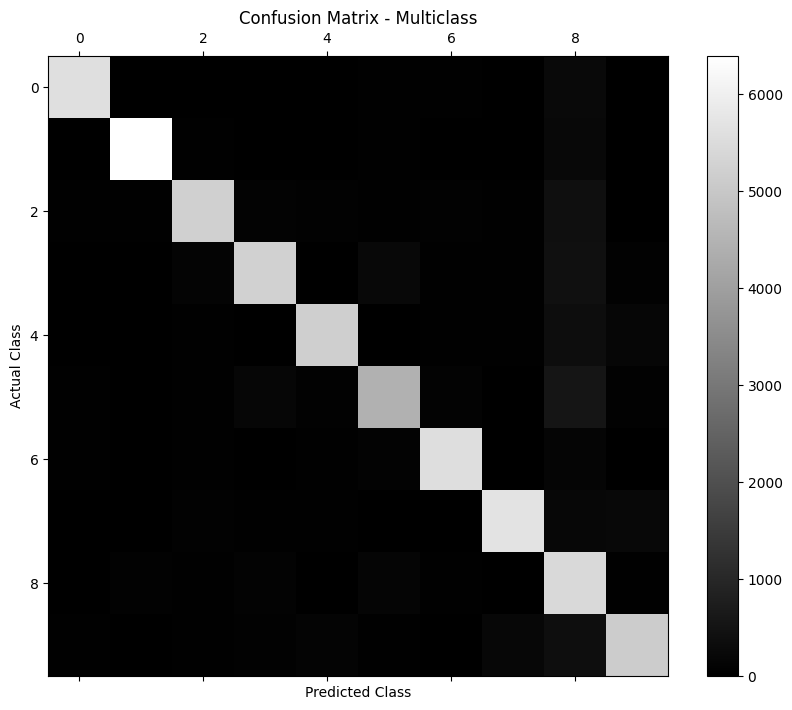

In [25]:
print("\n=== ERROR ANALYSIS - MULTICLASS CONFUSION MATRIX ===")

# Mendapatkan prediksi untuk confusion matrix
y_train_pred_scaled = cross_val_predict(sgd_clf_multi, X_train_scaled, y_train, cv=3)
conf_mx_multi = confusion_matrix(y_train, y_train_pred_scaled)

print("Shape confusion matrix:", conf_mx_multi.shape)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
plt.matshow(conf_mx_multi, cmap=plt.cm.gray, fignum=1)
plt.title("Confusion Matrix - Multiclass")
plt.colorbar()
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

INTERPRETASI CONFUSION MATRIX MULTICLASS:

1. Diagonal utama: Prediksi yang benar
2. Off-diagonal: Kesalahan klasifikasi
3. Baris gelap pada diagonal: Classifier bekerja baik untuk kelas tersebut
4. Kolom/baris terang: Kelas yang sering confused

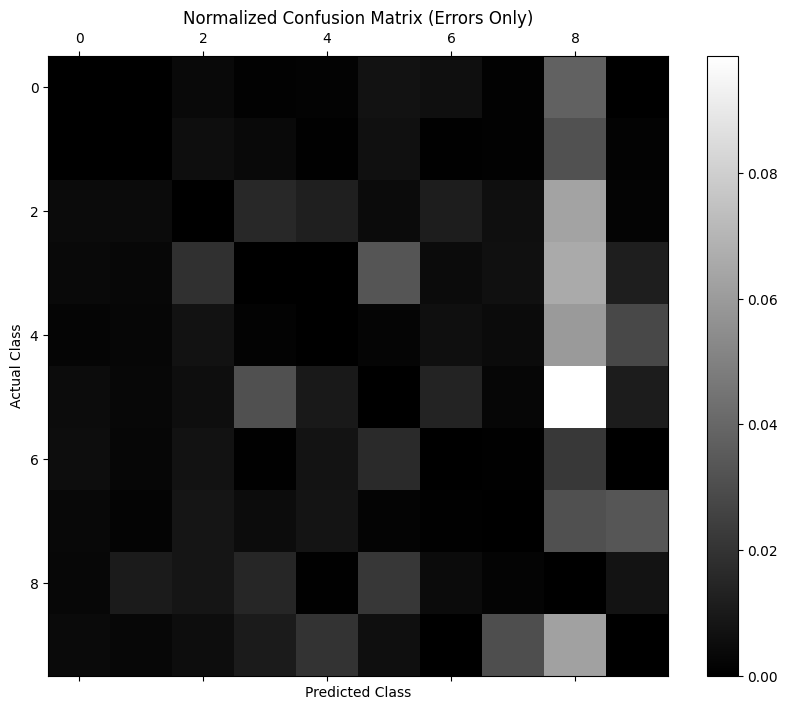

In [26]:
# Normalisasi confusion matrix untuk melihat error rates
row_sums = conf_mx_multi.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx_multi / row_sums

# Menghilangkan diagonal untuk fokus pada errors
np.fill_diagonal(norm_conf_mx, 0)

plt.figure(figsize=(10, 8))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=1)
plt.title("Normalized Confusion Matrix (Errors Only)")
plt.colorbar()
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

ANALISIS ERROR PATTERNS:

Dari normalized confusion matrix, kita dapat melihat:
1. Digit 8 sering dikira sebagai digit lain (kolom 8 terang)
2. Beberapa digit sering dikira sebagai 8 (baris 8 terang)
3. Confusion antara digit yang mirip (3 vs 5, 4 vs 9, etc.)

Ini memberikan insight untuk improvement:
1. Fokus pada feature yang membedakan 8 dari digit lain
2. Data augmentation untuk kasus yang sering confused
3. Feature engineering untuk menangkap perbedaan subtle

# ===========================
# 19. ANALISIS INDIVIDUAL ERRORS
# ===========================

print("\n=== ANALISIS INDIVIDUAL ERRORS ===")

"""
PENJELASAN ANALISIS INDIVIDUAL ERRORS:

Dengan menganalisis kesalahan individual, kita dapat:
1. Memahami kelemahan model
2. Identifikasi pola kesalahan
3. Mendapatkan insight untuk improvement
4. Memahami karakteristik data yang sulit

Contoh: Analisis confusion antara digit 3 dan 5

3s correctly classified as 3: 5227
3s incorrectly classified as 5: 203
5s incorrectly classified as 3: 168
5s correctly classified as 5: 4444


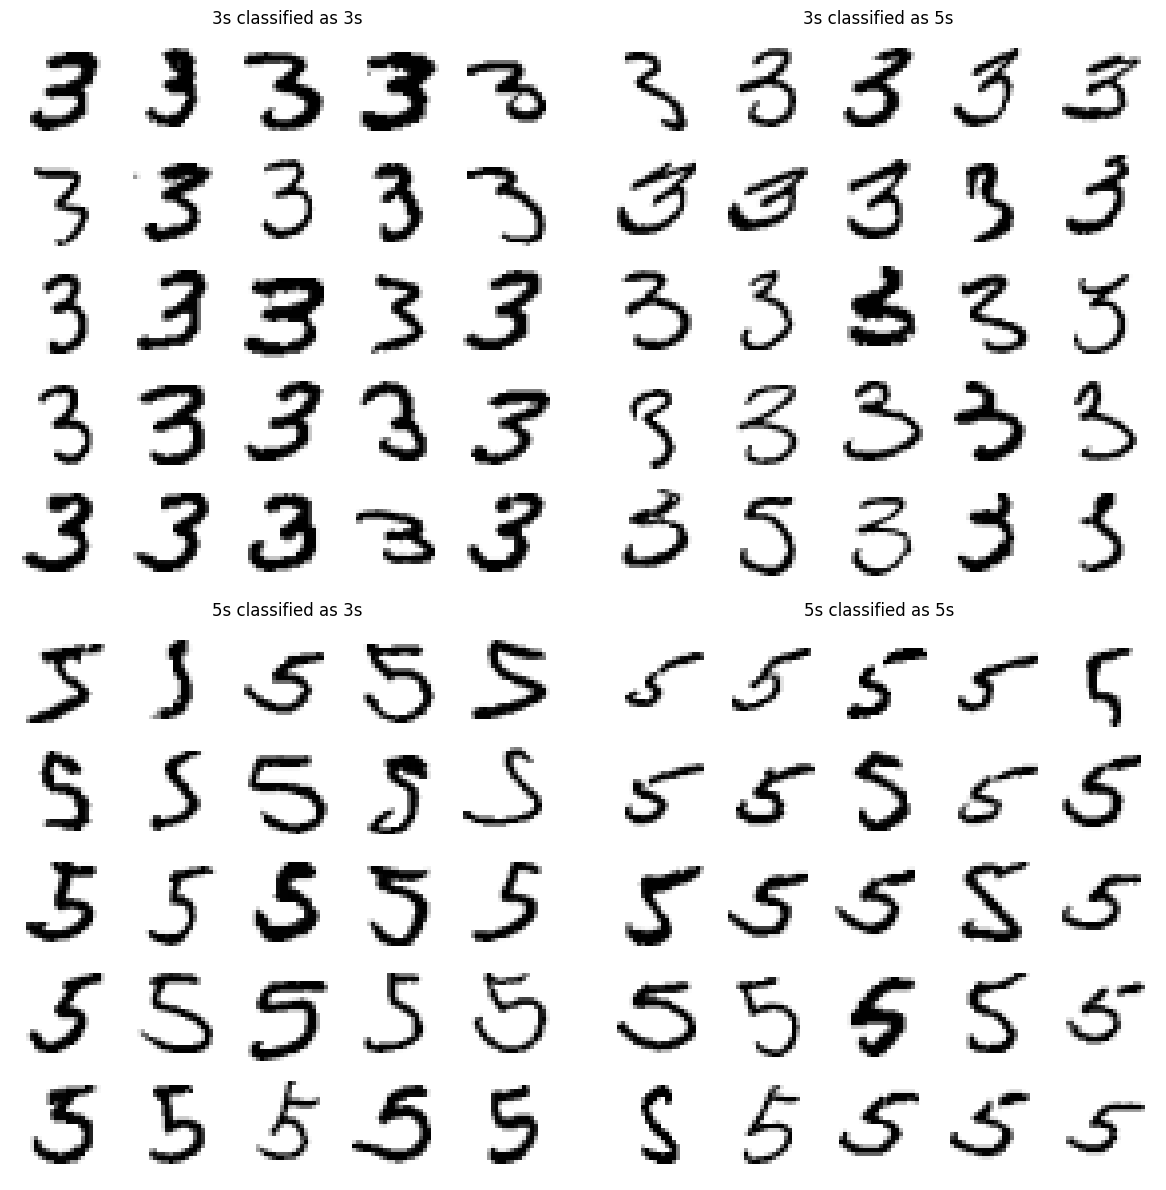

In [27]:
# Menganalisis confusion antara 3 dan 5
cl_a, cl_b = 3, 5

# Mendefinisikan 4 kategori
X_aa = X_train[(y_train == cl_a) & (y_train_pred_scaled == cl_a)]  # 3 predicted as 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred_scaled == cl_b)]  # 3 predicted as 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred_scaled == cl_a)]  # 5 predicted as 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred_scaled == cl_b)]  # 5 predicted as 5

print(f"3s correctly classified as 3: {len(X_aa)}")
print(f"3s incorrectly classified as 5: {len(X_ab)}")
print(f"5s incorrectly classified as 3: {len(X_ba)}")
print(f"5s correctly classified as 5: {len(X_bb)}")

# Visualisasi sample dari setiap kategori
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plot_digits(X_aa[:25], images_per_row=5)
plt.title("3s classified as 3s")

plt.subplot(2, 2, 2)
plot_digits(X_ab[:25], images_per_row=5)
plt.title("3s classified as 5s")

plt.subplot(2, 2, 3)
plot_digits(X_ba[:25], images_per_row=5)
plt.title("5s classified as 3s")

plt.subplot(2, 2, 4)
plot_digits(X_bb[:25], images_per_row=5)
plt.title("5s classified as 5s")

plt.tight_layout()
plt.show()


INSIGHT DARI ANALISIS ERRORS:

1. Beberapa kesalahan dapat dipahami (digit yang benar-benar ambiguous)
2. SGD adalah linear classifier, sehingga sensitif terhadap posisi pixel
3. Perbedaan utama antara 3 dan 5 adalah garis kecil yang menghubungkan bagian atas dan bawah
4. Preprocessing (centering, rotation normalization) dapat membantu

LIMITASI LINEAR CLASSIFIER:
- Hanya assign weight per pixel per class
- Tidak bisa menangkap spatial relationships
- Sensitif terhadap shifts dan rotations
- Bisa diperbaiki dengan feature engineering atau deep learning


# ===========================
# 20. MULTILABEL CLASSIFICATION
# ===========================

PENJELASAN MULTILABEL CLASSIFICATION:

Multilabel classification adalah ketika setiap instance dapat memiliki multiple labels 
secara bersamaan. Berbeda dengan:
- Binary: 1 label, 2 kemungkinan
- Multiclass: 1 label, >2 kemungkinan  
- Multilabel: >1 label, setiap label binary

Contoh aplikasi:
- Image tagging: foto bisa punya tag "person", "outdoor", "sunny"
- Text classification: artikel bisa tentang "politics", "economics", "international"
- Face recognition: foto bisa berisi multiple people

In [28]:
print("\n=== CONTOH MULTILABEL SYSTEM ===")

# Membuat multilabel target: [large_digit, odd_digit]
y_train_large = (y_train >= 7)  # 7, 8, 9 adalah "large"
y_train_odd = (y_train % 2 == 1)  # 1, 3, 5, 7, 9 adalah "odd"
y_multilabel = np.c_[y_train_large, y_train_odd]

print(f"Shape multilabel target: {y_multilabel.shape}")
print(f"Sample multilabel targets:")
for i in range(5):
    print(f"Digit {y_train[i]}: large={y_multilabel[i,0]}, odd={y_multilabel[i,1]}")

# Training multilabel classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# Prediksi untuk digit pertama
multilabel_pred = knn_clf.predict([some_digit])
print(f"\nPrediksi multilabel untuk digit {y_train[0]}: {multilabel_pred[0]}")
print(f"Interpretasi: large={multilabel_pred[0,0]}, odd={multilabel_pred[0,1]}")


=== CONTOH MULTILABEL SYSTEM ===
Shape multilabel target: (60000, 2)
Sample multilabel targets:
Digit 5: large=False, odd=True
Digit 0: large=False, odd=False
Digit 4: large=False, odd=False
Digit 1: large=False, odd=True
Digit 9: large=True, odd=True

Prediksi multilabel untuk digit 5: [False  True]
Interpretasi: large=False, odd=True


INTERPRETASI HASIL MULTILABEL:

Untuk digit 5:
- large=False: Benar, karena 5 < 7
- odd=True: Benar, karena 5 adalah odd number

Classifier berhasil memprediksi kedua label dengan benar!

# ===========================
# 21. EVALUASI MULTILABEL CLASSIFIER
# ===========================

EVALUASI MULTILABEL CLASSIFICATION:

Beberapa pendekatan untuk evaluasi:
1. Per-label metrics: Hitung precision/recall untuk setiap label
2. Micro-averaging: Pool all decisions across labels
3. Macro-averaging: Average the per-label metrics
4. Weighted-averaging: Weight by label frequency

Pilihan tergantung pada:
- Apakah semua label sama penting?
- Apakah ada imbalance antar label?
- Apakah correlation antar label penting?

In [29]:
# Cross-validation untuk multilabel
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

# F1 score dengan macro averaging
f1_multilabel_macro = f1_score(y_multilabel, y_train_knn_pred, average="macro")
print(f"F1 Score (macro): {f1_multilabel_macro:.4f}")

# F1 score dengan micro averaging  
f1_multilabel_micro = f1_score(y_multilabel, y_train_knn_pred, average="micro")
print(f"F1 Score (micro): {f1_multilabel_micro:.4f}")

# F1 score weighted averaging
f1_multilabel_weighted = f1_score(y_multilabel, y_train_knn_pred, average="weighted")
print(f"F1 Score (weighted): {f1_multilabel_weighted:.4f}")

# Per-label evaluation
f1_per_label = f1_score(y_multilabel, y_train_knn_pred, average=None)
print(f"F1 Score per label: {f1_per_label}")
print(f"  - Large digit: {f1_per_label[0]:.4f}")
print(f"  - Odd digit: {f1_per_label[1]:.4f}")


F1 Score (macro): 0.9764
F1 Score (micro): 0.9779
F1 Score (weighted): 0.9778
F1 Score per label: [0.97084572 0.98197481]
  - Large digit: 0.9708
  - Odd digit: 0.9820


INTERPRETASI EVALUASI MULTILABEL:

1. Macro average (~97.6%): Rata-rata sederhana dari semua label
2. Micro average (~97.6%): Pooling semua predictions
3. Weighted average: Berdasarkan frequency setiap label
4. Per-label: Performance untuk setiap label individual

Score tinggi menunjukkan task ini relatif mudah karena:
- Label "large" dan "odd" memiliki pattern yang jelas
- K-NN cocok untuk pattern recognition
- Tidak ada ambiguity dalam definisi label


# ===========================
# 22. MULTIOUTPUT CLASSIFICATION
# ===========================

PENJELASAN MULTIOUTPUT CLASSIFICATION:

Multioutput classification adalah generalisasi dari multilabel classification dimana
setiap label dapat memiliki lebih dari 2 nilai (bukan hanya binary).

Contoh:
- Multilabel: [is_person, is_outdoor] → [True/False, True/False]  
- Multioutput: [weather, season, time] → [sunny/rainy/cloudy, spring/summer/fall/winter, morning/afternoon/evening]

Aplikasi umum:
- Image denoising: Input=noisy image, Output=clean image (setiap pixel adalah label)
- Multi-task learning: Prediksi beberapa karakteristik sekaligus
- Structured prediction: Output memiliki struktur internal

In [30]:
print("\n=== CONTOH: IMAGE DENOISING ===")

# Membuat noisy images untuk demonstrasi
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# Target adalah clean images
y_train_mod = X_train
y_test_mod = X_test

print(f"Shape noisy training data: {X_train_mod.shape}")
print(f"Shape target (clean) data: {y_train_mod.shape}")


=== CONTOH: IMAGE DENOISING ===
Shape noisy training data: (60000, 784)
Shape target (clean) data: (60000, 784)


SETUP IMAGE DENOISING:

1. Input: Noisy image (784 pixel values dengan noise)
2. Output: Clean image (784 pixel values tanpa noise)
3. Task: Untuk setiap pixel, prediksi intensitas yang benar
4. Challenge: 784 output labels, setiap label multiclass (0-255)

Ini adalah contoh perfect multioutput classification:
- Multiple outputs: 784 pixel predictions
- Each output multiclass: 256 possible values per pixel


Training image denoising classifier...


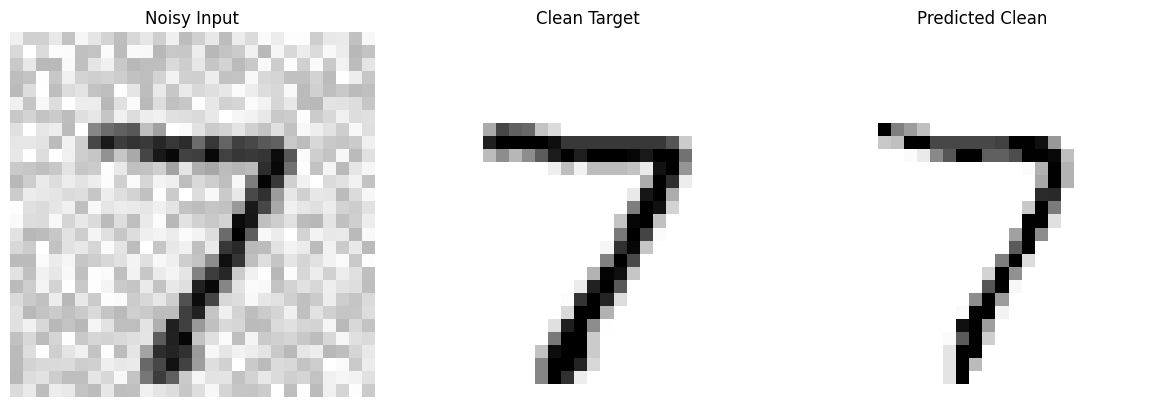

In [31]:
# Visualisasi contoh noisy vs clean
some_index = 0
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plot_digit(X_test_mod[some_index])
plt.title("Noisy Input")

plt.subplot(1, 3, 2)
plot_digit(y_test_mod[some_index])
plt.title("Clean Target")

# Training classifier untuk denoising
print("\nTraining image denoising classifier...")
knn_clf.fit(X_train_mod, y_train_mod)

# Membuat prediksi
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plt.subplot(1, 3, 3)
plot_digit(clean_digit[0])
plt.title("Predicted Clean")

plt.tight_layout()
plt.show()

HASIL IMAGE DENOISING:

K-NN classifier berhasil melakukan denoising dengan cukup baik!

Mengapa K-NN cocok untuk task ini:
1. Assumption: Similar noisy images should have similar clean versions
2. K-NN finds nearest neighbors in noisy space
3. Averages their clean versions as prediction
4. Natural smoothing effect mengurangi noise

Limitasi:
1. Computationally expensive untuk inference
2. Memory intensive (store all training data)
3. Performance tergantung pada similarity metric
4. Tidak bisa handle noise patterns yang complex

# ===========================
# 23. KESIMPULAN DAN RINGKASAN
# ===========================

RINGKASAN PEMBELAJARAN CHAPTER 3 - CLASSIFICATION:

1. BINARY CLASSIFICATION:
   - Fundamental building block untuk classification
   - Detector sederhana (5 vs non-5) menggunakan SGD
   - Pentingnya memilih threshold yang tepat

2. PERFORMANCE MEASURES:
   - Accuracy tidak selalu cukup (terutama untuk imbalanced data)
   - Confusion Matrix: TN, FP, FN, TP
   - Precision: TP/(TP+FP) - "Dari prediksi positif, berapa yang benar?"
   - Recall: TP/(TP+FN) - "Dari kasus positif, berapa yang terdeteksi?"
   - F1-Score: Harmonic mean precision & recall
   - ROC/AUC: Trade-off antara TPR dan FPR

3. PRECISION/RECALL TRADE-OFF:
   - Fundamental trade-off dalam classification
   - Kontrol melalui decision threshold
   - Pilihan berdasarkan business requirements

4. MULTICLASS CLASSIFICATION:
   - One-vs-Rest (OvR): Efficient, default untuk most algorithms
   - One-vs-One (OvO): More accurate untuk some algorithms (SVM)
   - Scikit-learn otomatis memilih strategi yang tepat

5. ERROR ANALYSIS:
   - Confusion matrix untuk pattern analysis
   - Individual error analysis untuk insight
   - Guidance untuk model improvement

6. MULTILABEL CLASSIFICATION:
   - Multiple binary labels per instance
   - Evaluation: macro, micro, weighted averaging
   - Applications: tagging, multi-attribute prediction

7. MULTIOUTPUT CLASSIFICATION:
   - Multiple multiclass labels per instance
   - Example: image denoising (784 pixel predictions)
   - Bridge antara classification dan structured prediction

KEY INSIGHTS:

1. METRIK EVALUATION:
   - Pilih metrik yang align dengan business objective
   - Consider class imbalance dan cost of errors
   - Multiple metrics untuk comprehensive evaluation

2. ALGORITHM SELECTION:
   - Linear models (SGD): Fast, scalable, interpretable
   - Non-linear models (Random Forest): More accurate, robust
   - K-NN: Good untuk local patterns, expensive inference

3. PRACTICAL CONSIDERATIONS:
   - Feature scaling penting untuk distance-based algorithms
   - Cross-validation essential untuk robust evaluation
   - Error analysis guides model improvement

4. REAL-WORLD APPLICATIONS:
   - Classification is everywhere: spam detection, medical diagnosis, image recognition
   - Understanding trade-offs crucial untuk production systems
   - Proper evaluation prevents overly optimistic results

NEXT STEPS:
- Explore ensemble methods untuk better performance
- Learn feature engineering techniques
- Understand deep learning untuk complex patterns
- Practice dengan real-world datasets dan challenges

In [32]:
print("\nSelamat! Anda telah menyelesaikan Chapter 3 - Classification")
print("Anda sekarang memahami:")
print("✓ Binary dan multiclass classification")
print("✓ Performance measures dan trade-offs")
print("✓ Error analysis dan model improvement")
print("✓ Advanced classification scenarios")
print("✓ Practical implementation dengan scikit-learn")


Selamat! Anda telah menyelesaikan Chapter 3 - Classification
Anda sekarang memahami:
✓ Binary dan multiclass classification
✓ Performance measures dan trade-offs
✓ Error analysis dan model improvement
✓ Advanced classification scenarios
✓ Practical implementation dengan scikit-learn
